<h1> Brain Tumor Classification (ResNet-50) </h1>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import tensorflow as tf
from tensorflow import keras

In [28]:
import random

In [29]:
np.random.seed(1)
tf.random.set_seed(1)

<h3> Split Data </h3>

In [30]:
#load file
train_folder = 'D:\\MRI BrainTumor\\Training' 
test_folder = 'D:\\MRI BrainTumor\\Testing'

In [31]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    shuffle = True,
    validation_split = 0.2,
    subset = 'training',
    seed = 1
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [32]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    shuffle = True,
    seed = 1
)
    

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [33]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    shuffle = False,
    seed = 1
)

Found 1311 files belonging to 4 classes.


In [34]:
#set classnames
train_class_names = train_dataset.class_names
val_class_names = val_dataset.class_names
test_class_names = test_dataset.class_names

<h3> Data Visualization </h3>

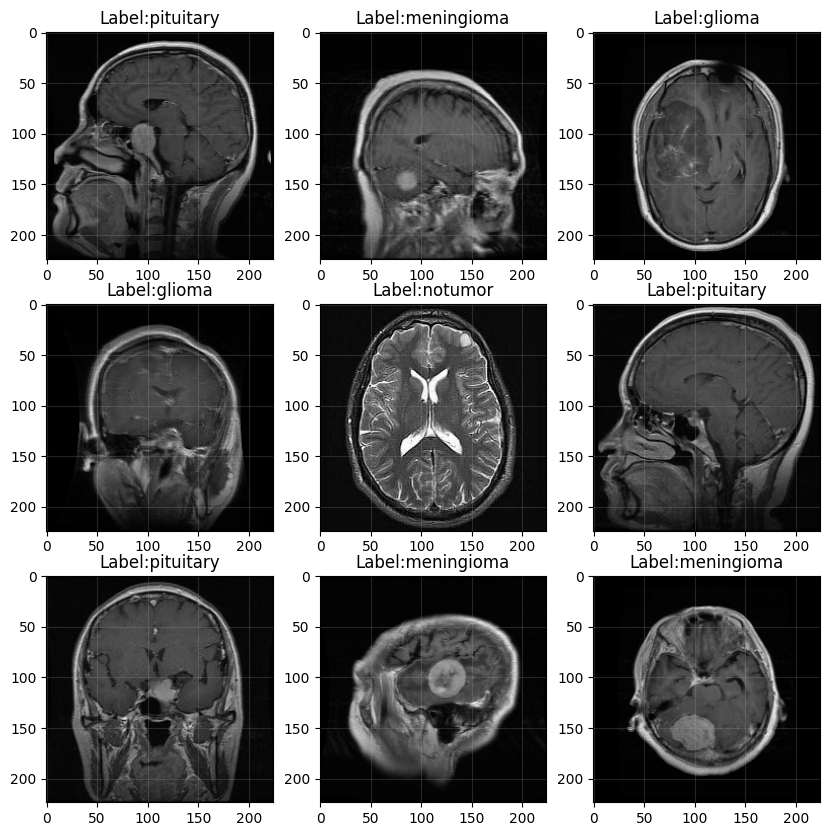

In [35]:
#display few images from dataset
def display_images (dataset, class_names, num_images = 9):
    plt.figure(figsize = (10,10))
    for i, (image, label) in enumerate(dataset.take(1)):
        for j in range (num_images):
            plt.subplot(3,3,j+1)
            plt.imshow(image[j].numpy().astype("uint8"))
            label_name = class_names[label [j].numpy()]
            plt.title(f"Label:{label_name}")
            plt.axis('on')
            plt.grid(alpha = 0.2)
        plt.show()
        break

display_images(train_dataset, train_class_names)          

<h3> Data Preprocessing </h3>

In [36]:
#data augmentation
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness, GaussianNoise

In [37]:
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomFlip('vertical'),
    RandomRotation(0.2),
    RandomZoom(0.3),
    RandomTranslation(height_factor=0.2, width_factor =0.2),
    RandomContrast(factor=0.0009),
    RandomBrightness(factor = 0.0009),
    GaussianNoise(0.1)
    
    
])

In [38]:
#preprocessing
def preprocess (image, label, training=True):
    if training:
        image = data_augmentation(image)
    image = tf.image.resize(image, (224,224))
    image = image/225
    return image, label
train_dataset_aug = train_dataset.map(lambda x,y:preprocess(x,y,training=True))
val_dataset_aug = val_dataset.map(lambda x,y:preprocess(x,y,training = False))
test_dataset_aug = test_dataset.map(lambda x,y:preprocess(x,y,training = False))

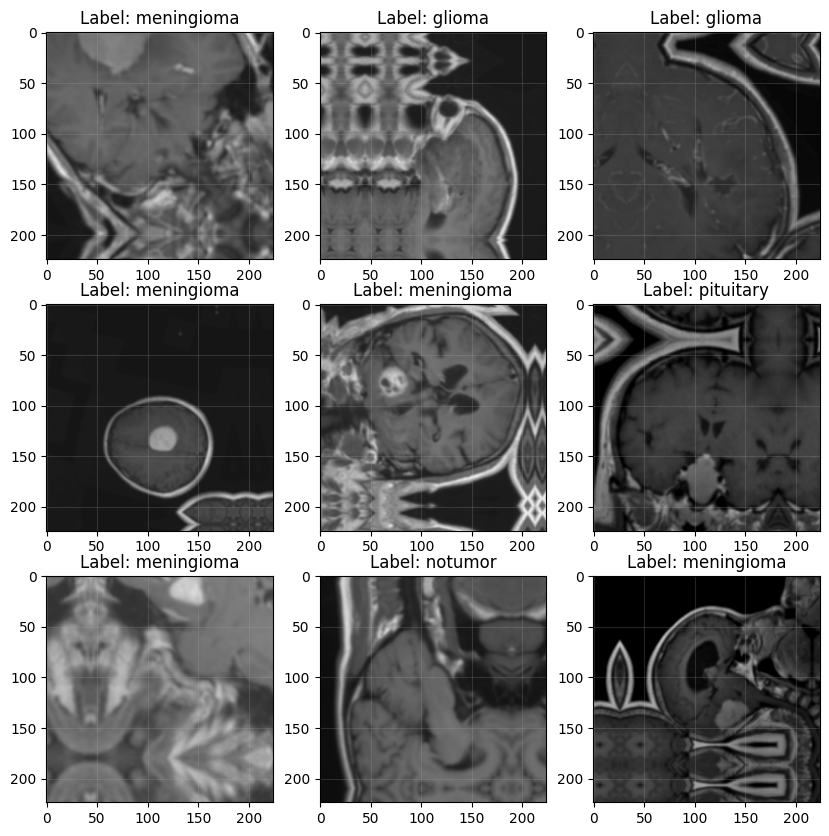

In [39]:
# Function to apply augmentation and display images
def display_augmented_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(1)):  # Take one batch from the dataset
        for j in range(num_images):  # Display 9 images
            augmented_image = data_augmentation(image[j:j+1])  # Apply augmentation to one image at a time
            augmented_image = augmented_image[0] * 225.0  # Convert back to [0, 255] range
            augmented_image = tf.clip_by_value(augmented_image, 0, 255)  # Ensure values stay within [0, 255] range
            plt.subplot(3, 3, j+1)  # Create a 3x3 grid
            plt.imshow(augmented_image.numpy().astype("uint8"))  # Convert to NumPy and display
            label_name = class_names[label[j].numpy()]  # Map the label index to class name
            plt.title(f"Label: {label_name}")  # Display label name
            plt.axis('on')
            plt.grid(alpha =0.2) 
        plt.show()
        break  # Stop after displaying the first batch

# Show augmented images from the training dataset
display_augmented_images(train_dataset_aug, train_class_names)

<h3> Model Building </h3>

In [40]:
#Build Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2 

In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D 
from tensorflow.keras.models import Model

In [42]:
base_model_res = ResNet50( weights = 'imagenet', 
                      include_top = False, 
                      input_shape = (224,224,3))

<h3> Fine-Tuning </h3>

In [52]:
print(f"Total layers in base_model_res: {len(base_model_res.layers)}")

Total layers in base_model_res: 175


In [53]:
for i, layer in enumerate(base_model_res.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")


Layer 0: input_layer_3, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False
Layer 22: conv2_block2_2_conv, Tra

In [74]:
# Freeze all layers
for layer in base_model_res.layers:  
    layer.trainable = False

In [66]:
model = Sequential([
    base_model_res,
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(train_class_names), activation = 'softmax')

])


In [67]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,308 (91.99 MB)

 Trainable params: 526,084 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

<h3> Compile Model </h3>

In [68]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [69]:
model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
             )

In [70]:
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6,
    verbose = 1
)

In [71]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 6,
    restore_best_weights=True
)

In [72]:
#train model
history = model.fit(
    train_dataset_aug,
    validation_data = val_dataset_aug,
    epochs = 100,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5499 - loss: 1.3993 - val_accuracy: 0.4536 - val_loss: 2.2190 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.6138 - loss: 1.1656 - val_accuracy: 0.2758 - val_loss: 4.0832 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.6185 - loss: 1.1066 - val_accuracy: 0.2688 - val_loss: 6.8844 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.6331 - loss: 1.0382 - val_accuracy: 0.4011 - val_loss: 2.0008 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.6331 - loss: 1.0178 - val_accuracy: 0.4912 - val_loss: 1.6525 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.6506 - loss: 0.9937 - val_accuracy: 0.4422 - val_loss: 1.6465 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.6338 - l

<h2> Test Accuracy and Loss </h2>

In [73]:
test_loss, test_accuracy = model.evaluate(test_dataset_aug)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 798ms/step - accuracy: 0.2536 - loss: 3.0146
Test Loss: 1.8788
Test Accuracy: 0.4996


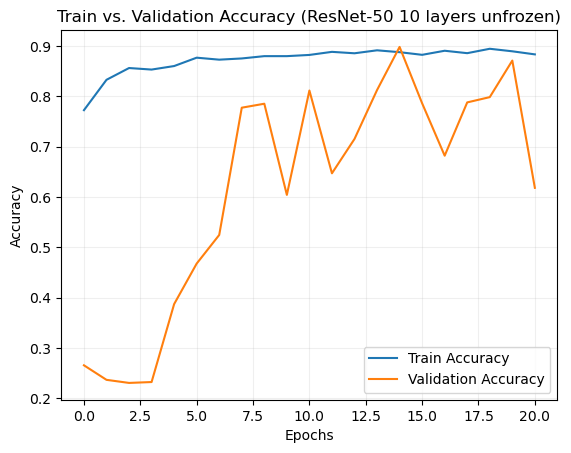

In [61]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Accuracy (ResNet-50 10 layers unfrozen)")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('resnet accuracy 10 layers.png')
plt.show()


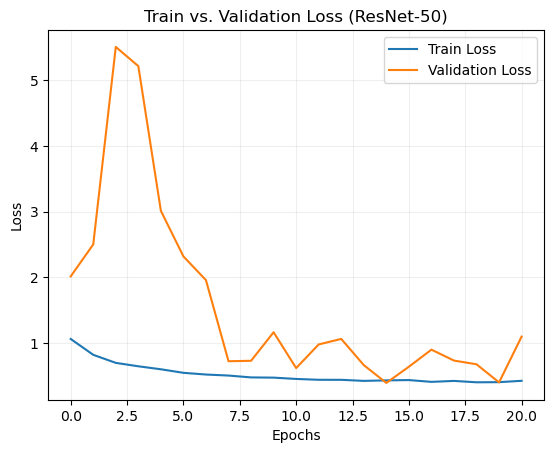

In [81]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Train vs. Validation Loss (ResNet-50)")
plt.legend()
plt.grid(alpha =0.2)
plt.savefig('resnet Loss 10 layers.png')
plt.show()


<h2> Confusion Matrix </h2>

In [64]:
# Generate predictions
y_pred_probs = model.predict(test_dataset_aug)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step


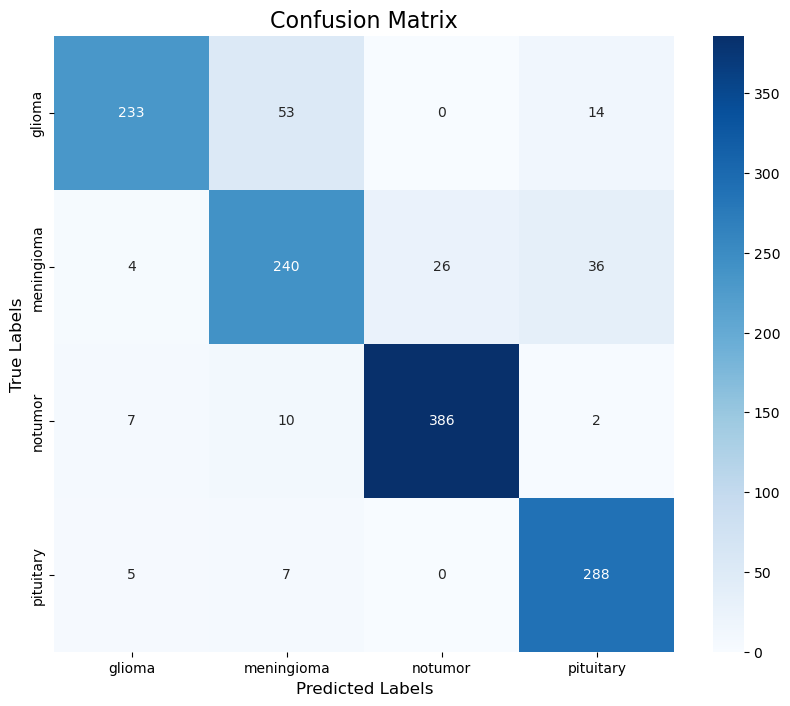

In [66]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_names, yticklabels=test_class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.savefig('Confusion Matrix (Resnet-50 10 layers cm)')
plt.show()


<h2> Model Evaluation </h2>

In [78]:
# Extract training history
history_data = history.history  # Access the history attribute

# Compute the mean and standard deviation for loss
train_loss = history_data['loss']
val_loss = history_data['val_loss']

train_loss_mean = np.mean(train_loss)
train_loss_std = np.std(train_loss)
val_loss_mean = np.mean(val_loss)
val_loss_std = np.std(val_loss)

# Compute the confidence interval (95%) for loss
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)  # Standard Error
    h = se * 1.96  # t-value for 95% CI
    return mean - h, mean + h

# Confidence interval for training and validation loss
train_loss_ci = confidence_interval(train_loss)
val_loss_ci = confidence_interval(val_loss)

print(f"Train Loss - Mean: {train_loss_mean:.4f}, Std: {train_loss_std:.4f}, 95% CI: {train_loss_ci}")
print(f"Validation Loss - Mean: {val_loss_mean:.4f}, Std: {val_loss_std:.4f}, 95% CI: {val_loss_ci}")

# Compute the mean and standard deviation for accuracy
train_accuracy = history_data['accuracy']
val_accuracy = history_data['val_accuracy']

train_acc_mean = np.mean(train_accuracy)
train_acc_std = np.std(train_accuracy)
val_acc_mean = np.mean(val_accuracy)
val_acc_std = np.std(val_accuracy)

# Compute the confidence interval (95%) for accuracy
train_acc_ci = confidence_interval(train_accuracy)
val_acc_ci = confidence_interval(val_accuracy)

print(f"Train Accuracy - Mean: {train_acc_mean:.4f}, Std: {train_acc_std:.4f}, 95% CI: {train_acc_ci}")
print(f"Validation Accuracy - Mean: {val_acc_mean:.4f}, Std: {val_acc_std:.4f}, 95% CI: {val_acc_ci}")

Train Loss - Mean: 0.5224, Std: 0.1609, 95% CI: (0.45357089873183787, 0.5911652964464211)
Validation Loss - Mean: 1.5843, Std: 1.4223, 95% CI: (0.9760046012056817, 2.1926739095510377)
Train Accuracy - Mean: 0.8727, Std: 0.0268, 95% CI: (0.8611814394177367, 0.8841348048892818)
Validation Accuracy - Mean: 0.6162, Std: 0.2215, 95% CI: (0.5214839739906658, 0.7109403377039789)


In [79]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Predicting on the training data
train_true_labels = []
train_pred_labels = []

for images, labels in train_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    train_true_labels.extend(labels.numpy())  # True labels
    train_pred_labels.extend(predicted_labels)  # Predicted labels

# Predicting on the validation data
val_true_labels = []
val_pred_labels = []

for images, labels in val_dataset_aug:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class
    val_true_labels.extend(labels.numpy())  # True labels
    val_pred_labels.extend(predicted_labels)  # Predicted labels

# Calculate F1 score for training data
train_f1_score = f1_score(train_true_labels, train_pred_labels, average='weighted')  # Use 'weighted' for class imbalance
# Calculate F1 score for validation data
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='weighted')  # Use 'weighted' for class imbalance

print(f"Training F1 Score: {train_f1_score:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")

# You can also print a full classification report with precision, recall, and F1 for each class
print("\nClassification Report for Training Data:")
print(classification_report(train_true_labels, train_pred_labels, target_names=train_class_names))

print("\nClassification Report for Validation Data:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load image in grayscale mode and resize
    img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
    
    # Convert image to numpy array and expand dimensions to match model input shape
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    
    # Normalize image values to [0, 1]
    img_array = img_array / 255.0
    
    return img_array

# Function to predict the class of the image
def predict_image(model, img_array, class_names):
    # Get model predictions (probabilities)
    predictions = model.predict(img_array)
    
    # Get the predicted class label (index of the highest probability)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_idx]
    
    return predicted_class_name, predictions[0][predicted_class_idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class: glioma
Prediction Probability: 0.9374


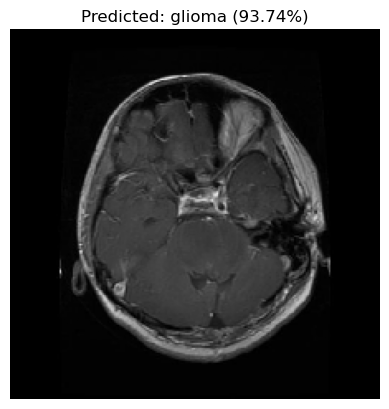

In [77]:
# Load and preprocess the image
img_path = 'D:\\Datasets\\new data\\gg.jpg'  # Provide the path to the MRI image
processed_image = load_and_preprocess_image(img_path)

# Predict the class
predicted_class_name, predicted_prob = predict_image(model, processed_image, test_class_names)

# Display the result
print(f"Predicted Class: {predicted_class_name}")
print(f"Prediction Probability: {predicted_prob:.4f}")

# Display the image and prediction
plt.imshow(processed_image[0].squeeze())  # Use cmap="gray" for grayscale images
plt.title(f"Predicted: {predicted_class_name} ({predicted_prob*100:.2f}%)")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

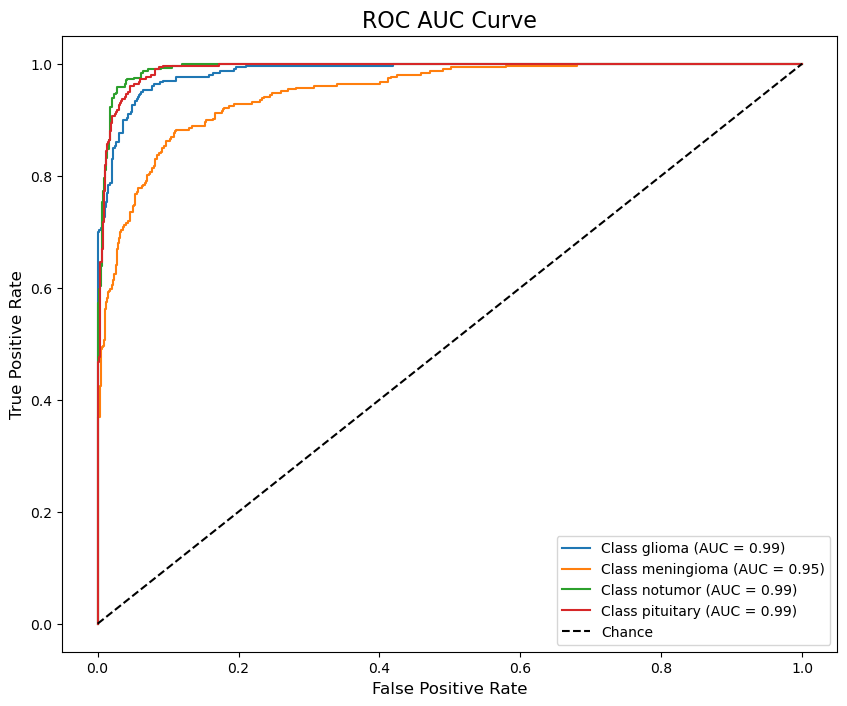

In [80]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
y_true = []
y_pred_proba = []

for images, labels in test_dataset_aug:
    y_true.extend(labels.numpy())
    y_pred_proba.extend(model.predict(images))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=range(len(test_class_names)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(test_class_names):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels and legend
plt.title('ROC AUC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid
plt.savefig('ROC AUC Curve (ResNet: 10 layers)')
plt.show()
